# Parameter Inference

Here we infer the parameters of the systems we have observed.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tqdm, tqdm_notebook
from true_params import uncert

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Now we compile the model and fit one of the systems just to check:

In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    thetas = array(f['thetas'])
    
    mcobs = array(f['mcobs'])
    etaobs = array(f['etaobs'])
    rhoobs = array(f['rhoobs'])
    thetaobs = array(f['thetaobs'])
    
    sigma_mc = array(f['sigma_mc'])
    sigma_eta = array(f['sigma_eta'])
    sigma_rho = array(f['sigma_rho'])
    sigma_theta = array(f['sigma_t'])
    
with h5py.File('optimal_snr.h5', 'r') as f:
    ms_osnr = array(f['ms'])
    osnrs = array(f['SNR'])

In [4]:
model = pystan.StanModel('infer.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38b7065cd7423b040a76b599a7fbaf11 NOW.
/mnt/home/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp1e5n1jwx/stanfit4anon_model_38b7065cd7423b040a76b599a7fbaf11_5766864837080361158.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We try to fit the system with the largest $d_L$, just because it will probably be the most biased fit.

In [6]:
ifit = argmax(dls)

data = {
    'mc_obs': mcobs[ifit],
    'eta_obs': etaobs[ifit],
    'rho_obs': rhoobs[ifit],
    'theta_obs': thetaobs[ifit],
    
    'sigma_mc': sigma_mc[ifit],
    'sigma_eta': sigma_eta[ifit],
    'sigma_theta': sigma_theta[ifit],
    
    'nm': len(ms_osnr),
    'ms': ms_osnr,
    'opt_snrs': osnrs,
    
    'dL_max': Planck15.luminosity_distance(4).to(u.Gpc).value,
}

In [7]:
fit = model.sampling(data=data, init=({'m1': m1s[ifit]*(1+zs[ifit]), 'm2': m2s[ifit]*(1+zs[ifit]), 'dL': dls[ifit]},)*4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaf2430ef0>,
      dtype=object)

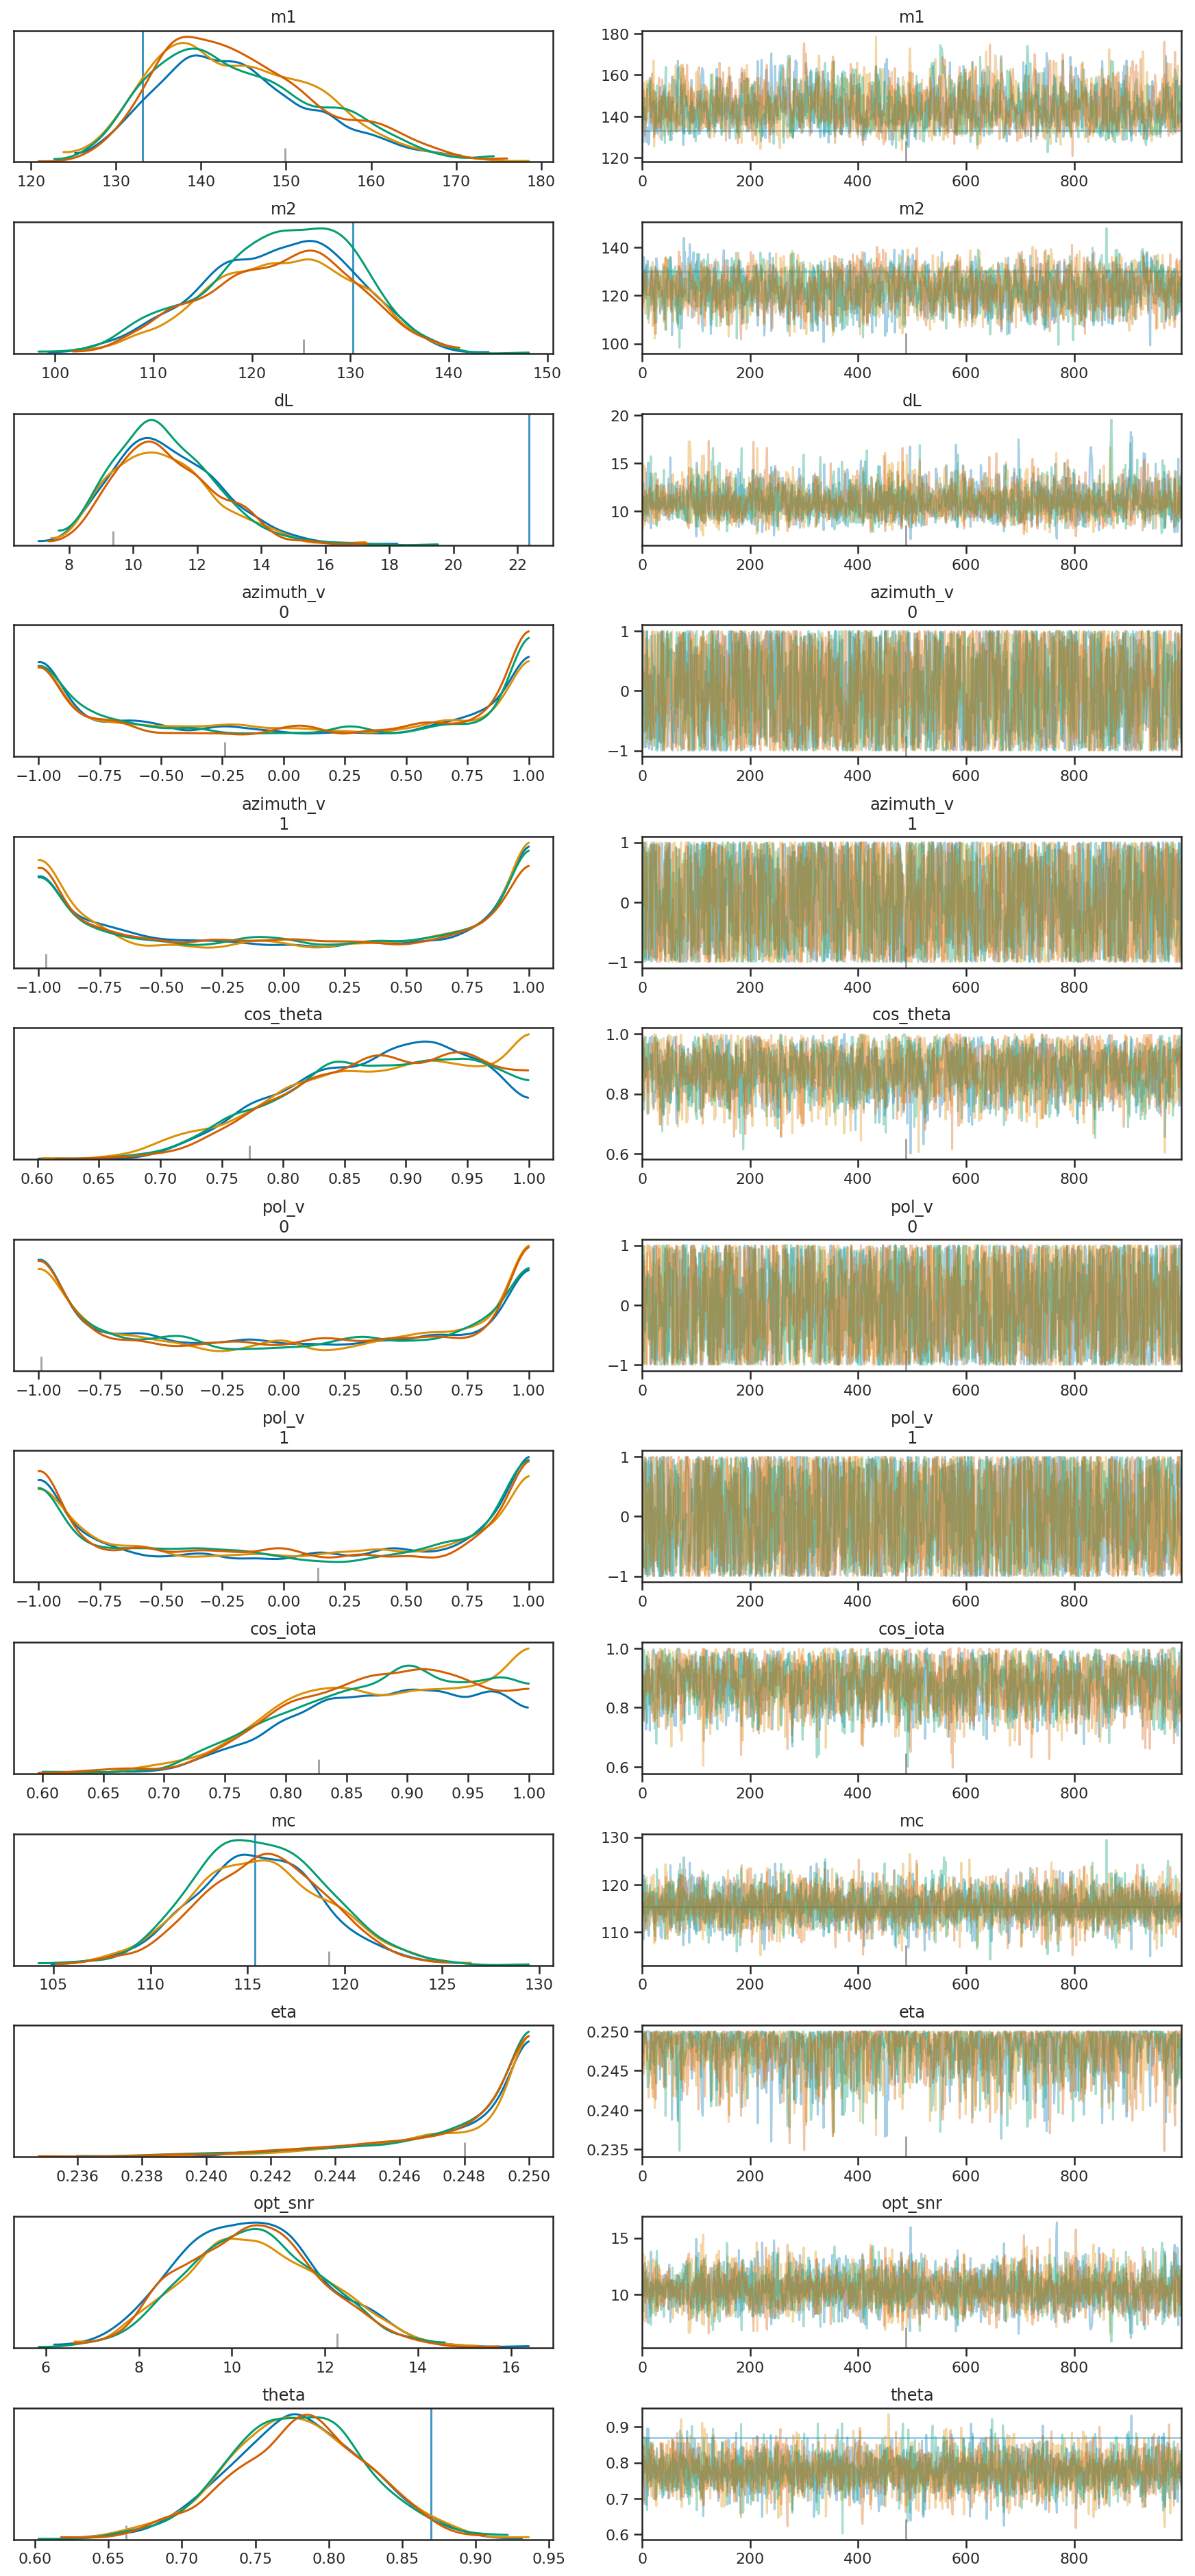

In [8]:
az.plot_trace(fit, lines=(('m1', {}, m1s[ifit]*(1+zs[ifit])),
                          ('m2', {}, m2s[ifit]*(1+zs[ifit])),
                          ('dL', {}, dls[ifit]),
                          ('theta', {}, thetas[ifit]),
                          ('mc', {}, mcobs[ifit])))

In [9]:
std(log(fit['m1']))

0.06434922775236375

Now we fit the whole thing!

Execute the cell below if you want to re-start the fit from the beginning:

In [16]:
with h5py.File('observations.h5', 'a') as f:
    del f['posteriors']
    pg = f.create_group('posteriors')
    nobs = len(mcobs)
    nsamp = 4000
    pg.create_dataset('dl', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m1det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m2det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('theta', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)

In [ ]:
with h5py.File('observations.h5', 'a') as f:
    pg = f['posteriors']
    
    for i in tqdm(range(len(mcobs))):
        # Assuming that m == 0 means it hasn't been fit before, and anything else means that it has
        if pg['m1det'][i,0] == 0:
            data = {
                'mc_obs': mcobs[i],
                'eta_obs': etaobs[i],
                'rho_obs': rhoobs[i],
                'theta_obs': thetaobs[i],

                'sigma_mc': sigma_mc[i],
                'sigma_eta': sigma_eta[i],
                'sigma_theta': sigma_theta[i],

                'nm': len(ms_osnr),
                'ms': ms_osnr,
                'opt_snrs': osnrs,

                'dL_max': Planck15.luminosity_distance(4).to(u.Gpc).value
            }

            init = {
                'm1': m1s[i]*(1+zs[i]),
                'm2': m2s[i]*(1+zs[i]),
                'dL': dls[i]
            }

            fit = model.sampling(data=data, iter=500, init=16*(init,), chains=16)
            chain = fit.extract(permuted=True)

            pg['dl'][i,:] = chain['dL']
            pg['m1det'][i,:] = chain['m1']
            pg['m2det'][i,:] = chain['m2']
            pg['theta'][i,:] = chain['theta']



  0%|          | 0/3461 [00:00<?, ?it/s]WARNING:pystan:54 of 4000 iterations ended with a divergence (1.35%).


  0%|          | 1/3461 [00:01<1:10:17,  1.22s/it]WARNING:pystan:29 of 4000 iterations ended with a divergence (0.725%).


  0%|          | 2/3461 [00:02<1:10:26,  1.22s/it]WARNING:pystan:31 of 4000 iterations ended with a divergence (0.775%).


  0%|          | 3/3461 [00:03<1:09:57,  1.21s/it]

  0%|          | 4/3461 [00:04<1:04:45,  1.12s/it]WARNING:pystan:24 of 4000 iterations ended with a divergence (0.6%).


  0%|          | 5/3461 [00:05<1:04:19,  1.12s/it]WARNING:pystan:17 of 4000 iterations ended with a divergence (0.425%).


  0%|          | 6/3461 [00:07<1:09:02,  1.20s/it]WARNING:pystan:4 of 4000 iterations ended with a divergence (0.1%).


  0%|          | 7/3461 [00:07<1:04:42,  1.12s/it]

  0%|          | 8/3461 [00:08<1:01:35,  1.07s/it]WARNING:pystan:2 of 4000 iterations ended with a divergence (0.05%).


  0%|          | 9/3461 [00:09<1:01:19,  1.07s/it]W

## Checking results

In [55]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1det_samples = array(f['posteriors']['m1det'])
    m2det_samples = array(f['posteriors']['m2det'])
    dl_samples = array(f['posteriors']['dl'])
    theta_samples = array(f['posteriors']['theta'])

First, let's look at some z-scores for $m_1$, $m_2$, and $d_L$:

Text(0, 0.5, '$p\\left( z_{d_L} \\right)$')

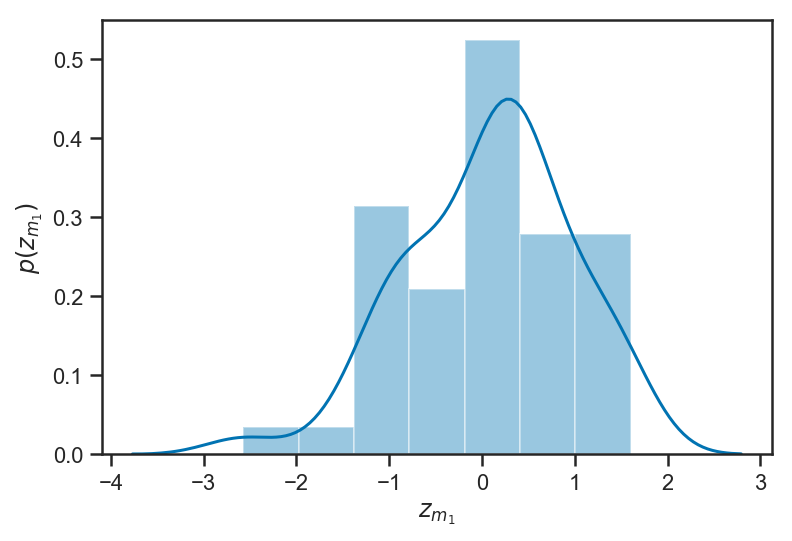

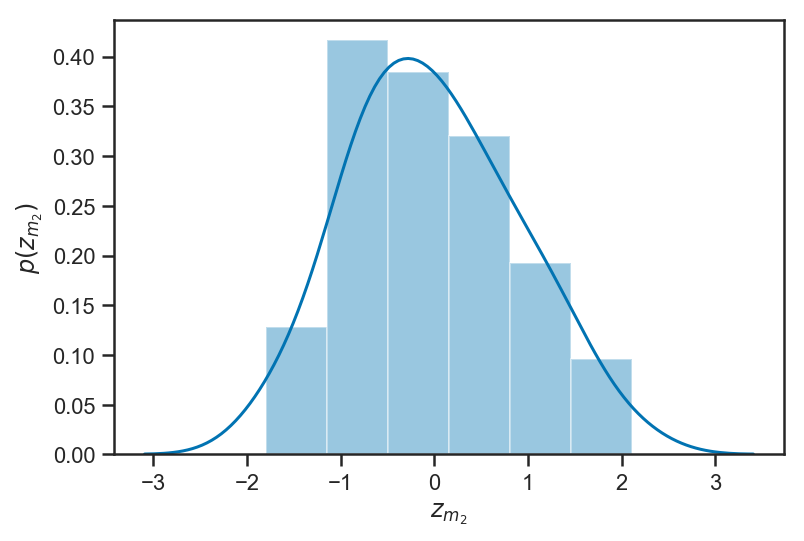

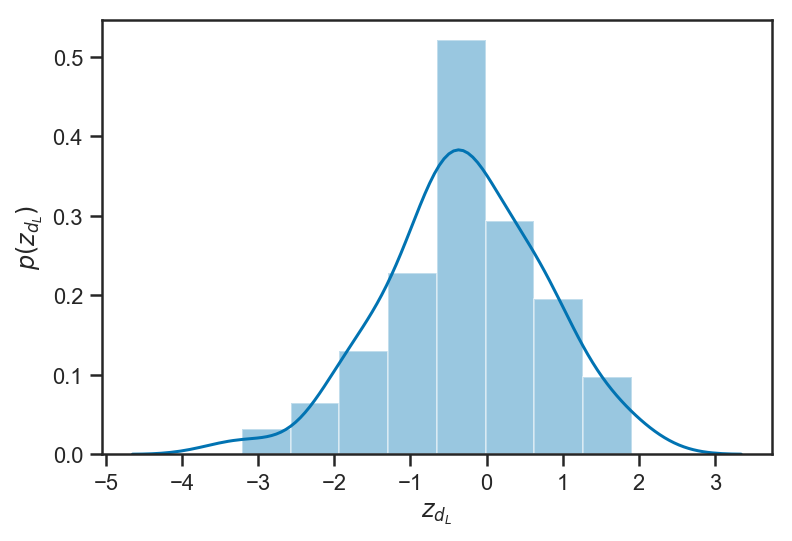

In [56]:
zscore_m1 = mean(m1det_samples - m1s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m1det_samples, axis=1)
sns.distplot(zscore_m1)
xlabel(r'$z_{m_1}$')
ylabel(r'$p\left( z_{m_1} \right)$')

figure()
zscore_m2 = mean(m2det_samples - m2s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m2det_samples, axis=1)
sns.distplot(zscore_m2)
xlabel(r'$z_{m_2}$')
ylabel(r'$p\left( z_{m_2} \right)$')

figure()
zscore_dl = mean(dl_samples - dls[:,newaxis], axis=1)/std(dl_samples, axis=1)
sns.distplot(zscore_dl)
xlabel(r'$z_{d_L}$')
ylabel(r'$p\left( z_{d_L} \right)$')

We are just looking for major outliers (since we have drawn 4M objects or so, out to $z = 3$, we expect even some 4-5 sigma outliers).  No surprises, I guess.

Another test we can do is to check the median uncertainties in masses and distances, and compare against GW170814.  The agreement is striking (well, we tuned it to be this way).

In [57]:
print('median 90% CI in log(m1) is {:.2f}'.format(median(quantile(log(m1det_samples), 0.95, axis=1) - quantile(log(m1det_samples), 0.05, axis=1))))
print('median 90% CI in log(m2) is {:.2f}'.format(median(quantile(log(m2det_samples), 0.95, axis=1) - quantile(log(m2det_samples), 0.05, axis=1))))
print('median 90% CI in log(dL) is {:.2f}'.format(median(quantile(log(dl_samples), 0.95, axis=1) - quantile(log(dl_samples), 0.05, axis=1))))

print()

print('GW170814 had {:.2f}, {:.2f}, {:.2f}'.format(log(30.5+5.7)-log(30.5-3.0), log(25.3+2.8)-log(25.3-4.2), log(540+130)-log(540-210)))

median 90% CI in log(m1) is 0.20
median 90% CI in log(m2) is 0.19
median 90% CI in log(dL) is 0.43

GW170814 had 0.27, 0.29, 0.71


In order to generate reliable selection effects, we need a dLmax that encloses the entire sample.

In [58]:
print('maximum estimated dL is {:.1f} Gpc'.format(np.max(dl_samples))), Planck15.luminosity_distance(3).to(u.Gpc)

maximum estimated dL is 14.6 Gpc


(None, <Quantity 26.03918355 Gpc>)